# Solve PONG using frames



In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from gym import spaces
import cv2
from wrappers import NoopResetEnv, ProcessFrame84
import pickle
import os

env = gym.make('Pong-v4')
env = NoopResetEnv(env, noop_max=7)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(1, 84, 84)
75
121
-0.4140625
-0.0546875


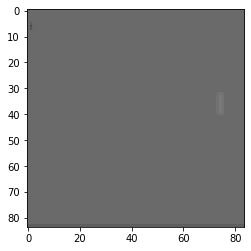

In [2]:
frame = env.reset()

def process_frame(frame, test=False):
    if frame.size == 210 * 160 * 3:
        img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
    elif frame.size == 250 * 160 * 3:
        img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
    else:
        assert False, "Unknown resolution."
    img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
    resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
    x_t = resized_screen[18:102, :]
    x_t = np.reshape(x_t, [84, 84, 1])
    x_t = x_t.astype(np.uint8)
    if test:
        plt.imshow(np.concatenate([x_t,x_t,x_t],axis=2),
           interpolation='none')
    return np.swapaxes(x_t, 2, 0)

def preprocess_state(state):
    return (state)/128.0 - 1
    
frame = process_frame(frame, test=True)
print(frame.shape)
print(frame.min())
print(frame.max())
print(preprocess_state(frame).min())
print(preprocess_state(frame).max())
env.close()

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

class PrioritizedReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.priority = []
        self.position = 0
        self.indexes = []

    def increase_recent_priority(self, past):
        for i in self.indexes[-past:-2]:
            self.priority[i] += 2
            self.indexes = []
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            self.priority.append(0)
            
        while self.priority[self.position] > 0:
            self.priority[self.position] -= 1
            self.position = (self.position + 1) % self.capacity
        self.indexes.append(self.position)
        self.memory[self.position] = Transition(*args)
        if self.memory[self.position].reward.item() < 0:
            self.increase_recent_priority(30)
        
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.linear1 = nn.Linear(3136, 512)

        self.head = nn.Linear(512, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        return self.head(x)
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)
        


class DQN_basic(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN_basic, self).__init__()
        self.l1 = nn.Linear(128, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 128)
        self.head = nn.Linear(128, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return self.head(x)
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)



In [5]:
test = DQN(6)
res = test(torch.zeros([1, 3, 84, 84]))
print(res)
print(res.max(1))
print(res.max(1)[1].view(1,1))

tensor([[-0.0344, -0.0278, -0.0051, -0.0456, -0.0458, -0.0342]],
       grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([-0.0051], grad_fn=<MaxBackward0>),
indices=tensor([2]))
tensor([[2]])


In [16]:

name = "prioritized_50K_replay_2s"
def save_safe():
    if os.path.isfile(name+".loss"):
        raise FileExistsError("cant save experiment without overwriting")
def save_experiment():
    save_safe()
    pickle.dump( mean_rewards, open( name + ".loss", "wb" ))
    torch.save(policy_net.state_dict(), name + ".torch")

if os.path.isfile(name+".loss"):
    policy_net = None
    raise FileExistsError("cant save experiment without overwriting")

BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 100000
TARGET_UPDATE = 1000
tau = 0.001
PREFETCH = 10000
MEM_SIZE = 50000
learning_rate = 0.00025
past = 3

# Get number of actions from gym action space
n_actions = env.action_space.n

memory = PrioritizedReplayMemory(MEM_SIZE)
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)


steps_done = 0

eps = []
eps.append(EPS_START)
eps_threshold = 0

def get_eps1():
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    return eps_threshold

def get_eps2():
    global steps_done
    reduction = min(steps_done / EPS_DECAY, 1)
    steps_done += 1
    diff = EPS_START - EPS_END
    diff = diff*(1 - reduction)
    return EPS_END + diff
print(get_eps2())


def select_action(state, eps_max=1):
    global steps_done
    sample = random.random()
    eps_threshold = get_eps2()
    eps_threshold = min(eps_max, eps_threshold)
    eps.append(eps_threshold)
    if sample > eps_threshold:
        with torch.no_grad():
            res = policy_net(preprocess_state(state.float()))
            res = res.max(1)[1].view(1,1)
            return res
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def prefetch(n_prefetch):
    frame = env.reset()
    frames = [process_frame(frame)]*past
    state = torch.from_numpy(np.concatenate(frames)).to(device)
    print("Prefetching:", n_prefetch)
    while len(memory) < n_prefetch:
        if len(memory) % 1000 == 0:
            print(len(memory))
            
        action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
        frame, reward, done, _ = env.step(action.item())
        
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        if not done:
            frame = process_frame(frame)
            del frames[0]
            frames.append(frame)
            next_state = torch.from_numpy(np.concatenate(frames)).to(device)
        else:
            next_state = None
        
        memory.push(state, action, next_state, reward)
        state = next_state
        
        if done:
            frame = env.reset()
            frames = [process_frame(frame)]*past
            state = torch.from_numpy(np.concatenate(frames)).to(device)   
    


mean_max = 100
mean_rewards = []
episode_rewards = []
def plot_rewards():
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.axhline(y=0.0,color='black',linestyle='--')
    while len(mean_rewards) < len(episode_rewards):
        idx = len(mean_rewards)
        start = max(idx-mean_max, 0)
        curr = episode_rewards[start:idx+1]
        mean = sum(curr)/len(curr)
        mean_rewards.append(mean)
    plt.plot(episode_rewards)
    plt.plot(mean_rewards)
        
losses = []
losses_avg = []
def plot_losses():
    plt.title('Losses')
    plt.xlabel('steps')
    plt.ylabel('Loss')
    plt.plot(losses)
    # Take 100 episode averages and plot them too
    avg_length = 100
    while len(losses) > len(losses_avg) + avg_length:
        if len(losses_avg) == 0:
            losses_avg.append(sum(losses[:avg_length])/avg_length)
        else:
            i_rem = len(losses_avg) - 1
            i_add = i_rem + avg_length
            l_curr = losses_avg[-1]
            l_curr += (losses[i_add] - losses[i_rem])/avg_length
            losses_avg.append(l_curr)
    if len(losses_avg) > 0:
        plt.plot(losses_avg)
    
    
def plot_stuff():
    if is_ipython:
        display.clear_output(wait=True)
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plot_rewards()
    plt.subplot(122)
    plot_losses()
    plt.pause(0.001)

1.0


In [17]:

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = preprocess_state(torch.stack([s for s in batch.next_state
                                                if s is not None]).float())
    state_batch = preprocess_state(torch.stack(batch.state).float())
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

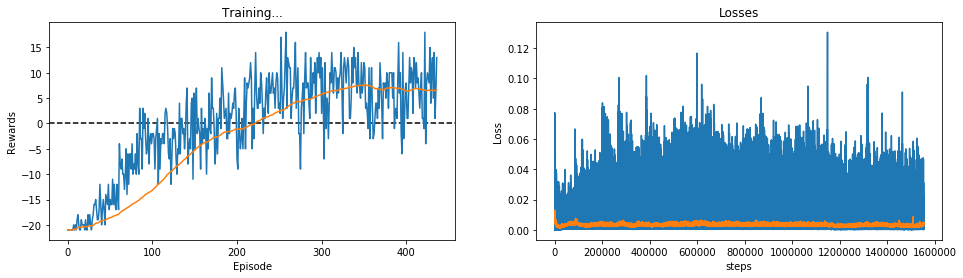

eps: 0.02
torch.Size([3, 84, 84])


KeyboardInterrupt: 

In [18]:
num_episodes = 600
save_safe()
prefetch(PREFETCH)   
env.close()
for i_episode in range(num_episodes):
    torch.cuda.empty_cache()
    # Initialize the environment and state
    frame = env.reset()
    frames = [process_frame(frame)]*past
    state = torch.from_numpy(np.concatenate(frames)).to(device)
    print("eps:", eps[-1])
    print(state.shape)
    total_reward = 0
    for t in count():
        # Select and perform an action
        env.render()
        action = select_action(state.unsqueeze(0))
        frame, reward, done, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        if not done:
            frame = process_frame(frame)
            del frames[0]
            frames.append(frame)
            next_state = torch.from_numpy(np.concatenate(frames)).to(device)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        optimize_model()
        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        #soft update
        #target_net.update_params(policy_net.state_dict(), tau)
        if done:
            episode_rewards.append(total_reward)
            plot_stuff()
            break
    # Update the target network, copying all weights and biases in DQN
    

print('Complete')
env.render()
env.close()
plot_rewards()
plt.ioff()
plt.show()
save_experiment()

In [19]:
save_experiment()

In [ ]:
steps_done = 50000
print(len(memory))

In [ ]:
torch.save(policy_net.state_dict(), "pong_cnn_batch32_2.torch")

In [ ]:


        
plot_stuff()

In [ ]:
env.close()